## Generative Adversarial Network

The idea behind Generative Adversarial Network (GANs) is that you have two Networks, a Generator G and a Discriminator D. The Generator is trained to fool the discriminator, it wants to output data that look as close as possible to real, training data. The discriminator also sees real training data and predicts if the data it's receive is real or fake.

In [119]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [120]:
from torchvision import datasets
import torchvision.transforms as transforms

#number of subprocesses to use for data loading
num_workers = 0
#how many samples per batch to load
batch_size = 64

#convert data to torch.FloatTensor
transform = transforms.ToTensor()

#get the training datasets
train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

#prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)


## Visualize the data

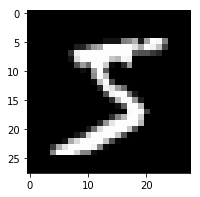

In [121]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.numpy()

#get one image from batch
img =  np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))

ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

## Define Discriminator Network

In [123]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        #x = x.reshape(1, -1)
        #x = x.squeeze()
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out

## Define Generator Network

In [124]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

## Model Hyperparameters

In [125]:
# Discriminator Hyperparameters
#size of the input image 28*28
input_size = 784
#size of the discriminator output (real or fake)
d_output_size = 1
#size of the last hidden layer in the discriminator
d_hidden_size = 32

# Generator Hyperparameters
#size of the laten vector to give to generator
z_size = 100
#size of discriminator output (generator image)
g_output_size = 784
#size of first hidden layer in the generator
g_hidden_size = 32

## Build Complete Network

In [126]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


## Discriminator and Generator Losses

### Discriminator loss

d_loss = d_real_loss + d_fake_loss
D(real_images) = 1 #label 1
D(fake_images) = 0 #label 0

Generalizing better, the labels are reducing a bit from 1 to 0.9
labels = torch.ones(size)*0.9

The discriminator loss for the fake data is similar. We want D(fake_images) = 0, where the fake images are the generator output fake_images = G(z)

### Generator loss

Objetive: Get D(fake_images) = 1
In this case, the labels are flipped to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real.

In [131]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [128]:
import torch.optim as optim
# Optimizaer hyperparameters
lr = 0.002
# create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

## Training

In [130]:
import pickle as pkl
import time

train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

start = time.time()

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode

end = time.time()
elapsed_time = end - start
print("elapsed_time = {} min, {} sec".format(elapsed_time//60, elapsed_time))

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Training on GPU
Epoch [    1/  100] | d_loss: 1.2146 | g_loss: 1.3028
Epoch [    1/  100] | d_loss: 1.3286 | g_loss: 0.9299
Epoch [    1/  100] | d_loss: 1.3791 | g_loss: 1.0073
Epoch [    2/  100] | d_loss: 1.3490 | g_loss: 1.2013
Epoch [    2/  100] | d_loss: 1.2762 | g_loss: 0.9018
Epoch [    2/  100] | d_loss: 1.4529 | g_loss: 1.0682
Epoch [    3/  100] | d_loss: 1.2392 | g_loss: 1.1219
Epoch [    3/  100] | d_loss: 1.2716 | g_loss: 0.9795
Epoch [    3/  100] | d_loss: 1.3352 | g_loss: 1.0906
Epoch [    4/  100] | d_loss: 1.2120 | g_loss: 1.3303
Epoch [    4/  100] | d_loss: 1.2718 | g_loss: 1.7070
Epoch [    4/  100] | d_loss: 1.2409 | g_loss: 1.0581
Epoch [    5/  100] | d_loss: 1.1766 | g_loss: 1.4765
Epoch [    5/  100] | d_loss: 1.2347 | g_loss: 1.0713
Epoch [    5/  100] | d_loss: 1.2443 | g_loss: 1.2500
Epoch [    6/  100] | d_loss: 1.2955 | g_loss: 1.0826
Epoch [    6/  100] | d_loss: 1.2235 | g_loss: 1.1158
Epoch [    6/  100] | d_loss: 1.3753 | g_loss: 0.9541
Epoch [    7

Epoch [   51/  100] | d_loss: 1.3187 | g_loss: 1.0293
Epoch [   52/  100] | d_loss: 1.3819 | g_loss: 1.3321
Epoch [   52/  100] | d_loss: 1.1516 | g_loss: 1.0726
Epoch [   52/  100] | d_loss: 1.3005 | g_loss: 1.1252
Epoch [   53/  100] | d_loss: 1.4706 | g_loss: 1.1909
Epoch [   53/  100] | d_loss: 1.2540 | g_loss: 1.0873
Epoch [   53/  100] | d_loss: 1.3990 | g_loss: 1.0827
Epoch [   54/  100] | d_loss: 1.3057 | g_loss: 0.9888
Epoch [   54/  100] | d_loss: 1.2841 | g_loss: 0.9245
Epoch [   54/  100] | d_loss: 1.3524 | g_loss: 0.9896
Epoch [   55/  100] | d_loss: 1.3228 | g_loss: 1.2409
Epoch [   55/  100] | d_loss: 1.2539 | g_loss: 0.9310
Epoch [   55/  100] | d_loss: 1.3772 | g_loss: 1.5121
Epoch [   56/  100] | d_loss: 1.3317 | g_loss: 1.2715
Epoch [   56/  100] | d_loss: 1.2990 | g_loss: 0.9543
Epoch [   56/  100] | d_loss: 1.3368 | g_loss: 1.0591
Epoch [   57/  100] | d_loss: 1.2724 | g_loss: 1.2942
Epoch [   57/  100] | d_loss: 1.3445 | g_loss: 1.0290
Epoch [   57/  100] | d_loss

In [132]:
#config 2
import torch.optim as optim
# Optimizaer hyperparameters
lr2 = 0.0002
# create optimizers for the discriminator and generator
d_optimizer2 = optim.Adam(D.parameters(), lr2)
g_optimizer2 = optim.Adam(G.parameters(), lr2)


# Discriminator Hyperparameters
#size of the input image 28*28
input_size2 = 784
#size of the discriminator output (real or fake)
d_output_size2 = 1
#size of the last hidden layer in the discriminator
d_hidden_size2 = 64

# Generator Hyperparameters
#size of the laten vector to give to generator
z_size2 = 200
#size of discriminator output (generator image)
g_output_size2 = 784
#size of first hidden layer in the generator
g_hidden_size2 = 64

# instantiate discriminator and generator
D2 = Discriminator(input_size2, d_hidden_size2, d_output_size2)
G2 = Generator(z_size2, g_hidden_size2, g_output_size2)

# check that they are as you expect
print(D2)
print()
print(G2)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=200, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


In [133]:
import pickle as pkl
import time

start = time.time()

# training hyperparams
num_epochs2 = 200

# keep track of loss and generated, "fake" samples
samples2 = []
losses2 = []

print_every2 = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size2))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D2.train()
G2.train()
for epoch in range(num_epochs2):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer2.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real2 = D2(real_images)
        d_real_loss2 = real_loss(D_real2, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size2))
        z = torch.from_numpy(z).float()
        fake_images = G2(z)
        
        # Compute the discriminator losses on fake images        
        D_fake2 = D2(fake_images)
        d_fake_loss2 = fake_loss(D_fake2)
        
        # add up loss and perform backprop
        d_loss2 = d_real_loss2 + d_fake_loss2
        d_loss2.backward()
        d_optimizer2.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer2.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size2))
        z = torch.from_numpy(z).float()
        fake_images = G2(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake2 = D2(fake_images)
        g_loss2 = real_loss(D_fake2) # use real loss to flip labels
        
        # perform backprop
        g_loss2.backward()
        g_optimizer2.step()

        # Print some loss stats
        if batch_i % print_every2 == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs2, d_loss2.item(), g_loss2.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses2.append((d_loss2.item(), g_loss2.item()))
    
    # generate and save sample, fake images
    G2.eval() # eval mode for generating samples
    samples_z = G2(fixed_z)
    samples2.append(samples_z)
    G2.train() # back to train mode

end = time.time()
elapsed_time = end - start
print("elapsed_time = {} min, {} sec".format(elapsed_time//60, elapsed_time))

# Save training generator samples
with open('train_samples2.pkl', 'wb') as f:
    pkl.dump(samples2, f)

Epoch [    1/  200] | d_loss: 1.4038 | g_loss: 0.6748
Epoch [    1/  200] | d_loss: 1.4067 | g_loss: 0.6753
Epoch [    1/  200] | d_loss: 1.3989 | g_loss: 0.6748
Epoch [    2/  200] | d_loss: 1.3958 | g_loss: 0.6757
Epoch [    2/  200] | d_loss: 1.4021 | g_loss: 0.6766
Epoch [    2/  200] | d_loss: 1.4021 | g_loss: 0.6774
Epoch [    3/  200] | d_loss: 1.4012 | g_loss: 0.6750
Epoch [    3/  200] | d_loss: 1.3943 | g_loss: 0.6757
Epoch [    3/  200] | d_loss: 1.4013 | g_loss: 0.6740
Epoch [    4/  200] | d_loss: 1.4000 | g_loss: 0.6763
Epoch [    4/  200] | d_loss: 1.3979 | g_loss: 0.6743
Epoch [    4/  200] | d_loss: 1.4004 | g_loss: 0.6764
Epoch [    5/  200] | d_loss: 1.3931 | g_loss: 0.6773
Epoch [    5/  200] | d_loss: 1.4011 | g_loss: 0.6749
Epoch [    5/  200] | d_loss: 1.4032 | g_loss: 0.6755
Epoch [    6/  200] | d_loss: 1.4093 | g_loss: 0.6758
Epoch [    6/  200] | d_loss: 1.4016 | g_loss: 0.6763
Epoch [    6/  200] | d_loss: 1.4018 | g_loss: 0.6751
Epoch [    7/  200] | d_loss

Epoch [   51/  200] | d_loss: 1.4016 | g_loss: 0.6755
Epoch [   52/  200] | d_loss: 1.4020 | g_loss: 0.6772
Epoch [   52/  200] | d_loss: 1.4030 | g_loss: 0.6759
Epoch [   52/  200] | d_loss: 1.4017 | g_loss: 0.6759
Epoch [   53/  200] | d_loss: 1.3969 | g_loss: 0.6764
Epoch [   53/  200] | d_loss: 1.4026 | g_loss: 0.6744
Epoch [   53/  200] | d_loss: 1.3965 | g_loss: 0.6740
Epoch [   54/  200] | d_loss: 1.4073 | g_loss: 0.6763
Epoch [   54/  200] | d_loss: 1.4021 | g_loss: 0.6753
Epoch [   54/  200] | d_loss: 1.4024 | g_loss: 0.6768
Epoch [   55/  200] | d_loss: 1.4005 | g_loss: 0.6769
Epoch [   55/  200] | d_loss: 1.4056 | g_loss: 0.6732
Epoch [   55/  200] | d_loss: 1.3985 | g_loss: 0.6769
Epoch [   56/  200] | d_loss: 1.4074 | g_loss: 0.6753
Epoch [   56/  200] | d_loss: 1.4047 | g_loss: 0.6766
Epoch [   56/  200] | d_loss: 1.4016 | g_loss: 0.6761
Epoch [   57/  200] | d_loss: 1.3918 | g_loss: 0.6746
Epoch [   57/  200] | d_loss: 1.4019 | g_loss: 0.6763
Epoch [   57/  200] | d_loss

Epoch [  102/  200] | d_loss: 1.4027 | g_loss: 0.6753
Epoch [  102/  200] | d_loss: 1.4027 | g_loss: 0.6772
Epoch [  103/  200] | d_loss: 1.4017 | g_loss: 0.6752
Epoch [  103/  200] | d_loss: 1.3983 | g_loss: 0.6746
Epoch [  103/  200] | d_loss: 1.3998 | g_loss: 0.6756
Epoch [  104/  200] | d_loss: 1.3987 | g_loss: 0.6760
Epoch [  104/  200] | d_loss: 1.4081 | g_loss: 0.6757
Epoch [  104/  200] | d_loss: 1.4027 | g_loss: 0.6750
Epoch [  105/  200] | d_loss: 1.3979 | g_loss: 0.6763
Epoch [  105/  200] | d_loss: 1.4064 | g_loss: 0.6746
Epoch [  105/  200] | d_loss: 1.3978 | g_loss: 0.6747
Epoch [  106/  200] | d_loss: 1.4061 | g_loss: 0.6747
Epoch [  106/  200] | d_loss: 1.4075 | g_loss: 0.6753
Epoch [  106/  200] | d_loss: 1.4044 | g_loss: 0.6743
Epoch [  107/  200] | d_loss: 1.3972 | g_loss: 0.6763
Epoch [  107/  200] | d_loss: 1.3990 | g_loss: 0.6756
Epoch [  107/  200] | d_loss: 1.3978 | g_loss: 0.6761
Epoch [  108/  200] | d_loss: 1.4005 | g_loss: 0.6758
Epoch [  108/  200] | d_loss

Epoch [  153/  200] | d_loss: 1.4016 | g_loss: 0.6758
Epoch [  153/  200] | d_loss: 1.4030 | g_loss: 0.6757
Epoch [  153/  200] | d_loss: 1.4046 | g_loss: 0.6753
Epoch [  154/  200] | d_loss: 1.3944 | g_loss: 0.6755
Epoch [  154/  200] | d_loss: 1.4035 | g_loss: 0.6767
Epoch [  154/  200] | d_loss: 1.4003 | g_loss: 0.6756
Epoch [  155/  200] | d_loss: 1.4008 | g_loss: 0.6744
Epoch [  155/  200] | d_loss: 1.4076 | g_loss: 0.6745
Epoch [  155/  200] | d_loss: 1.3995 | g_loss: 0.6755
Epoch [  156/  200] | d_loss: 1.4025 | g_loss: 0.6763
Epoch [  156/  200] | d_loss: 1.4040 | g_loss: 0.6743
Epoch [  156/  200] | d_loss: 1.3997 | g_loss: 0.6760
Epoch [  157/  200] | d_loss: 1.4054 | g_loss: 0.6754
Epoch [  157/  200] | d_loss: 1.4050 | g_loss: 0.6740
Epoch [  157/  200] | d_loss: 1.3909 | g_loss: 0.6755
Epoch [  158/  200] | d_loss: 1.3955 | g_loss: 0.6762
Epoch [  158/  200] | d_loss: 1.4086 | g_loss: 0.6751
Epoch [  158/  200] | d_loss: 1.3976 | g_loss: 0.6754
Epoch [  159/  200] | d_loss